In [1]:
import numpy as np
import pandas as pd
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

In [2]:
def read_csv_to_dataframe(csv_file):
    return pd.read_csv(csv_file)

In [3]:
# Custom Dataset
class exercisesDataset(Dataset):
    def __init__(self, dataframe, device):
        self.dataframe = dataframe
        self.device = device

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        keypoints = json.loads(self.dataframe.iloc[idx]['keypoints'])
        exercise = self.dataframe.iloc[idx]['exercise']
        movement = self.dataframe.iloc[idx]['movement']
        correctness = self.dataframe.iloc[idx]['correctness']

        # Convert keypoints to tensor
        keypoints_tensor = torch.tensor([v[:3] for v in keypoints.values()], dtype=torch.float32).flatten().to(self.device)

        # Convert labels to tensor
        exercise_label = torch.tensor(self.exercise_to_label(exercise), dtype=torch.long).to(self.device)
        movement_label = torch.tensor(self.movement_to_label(movement), dtype=torch.long).to(self.device)
        correctness_label = torch.tensor(int(correctness), dtype=torch.long).to(self.device)

        sample = {'image_path': image_path,'keypoints': keypoints_tensor, 'exercise': exercise_label, 'movement': movement_label, 'correctness': correctness_label}
        return sample

    def exercise_to_label(self, exercise):
        exercise_mapping = {'pushup': 0, 'squat': 1, 'deadlift': 2}
        return exercise_mapping[exercise]

    def movement_to_label(self, movement):
        movement_mapping = {'extension': 0, 'flexion': 1, 'other': 2}
        return movement_mapping[movement]


In [4]:
# Function to create a dataloader from a CSV file
def create_dataloader(csv_file, batch_size, device):
    df = pd.read_csv(csv_file)
    dataset = exercisesDataset(df, device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [6]:
# Define the ExercisesModel class
class ExercisesModel(nn.Module):
    def __init__(self, input_size, num_exercises, num_movements, num_correctness):
        super(ExercisesModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.exercise_head = nn.Linear(64, num_exercises)
        self.movement_head = nn.Linear(64, num_movements)
        self.correctness_head = nn.Linear(64, num_correctness)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        exercise_output = self.exercise_head(x)
        movement_output = self.movement_head(x)
        correctness_output = self.correctness_head(x)
        return exercise_output, movement_output, correctness_output


In [7]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [79]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct_exercise = 0
    total_correct_movement = 0
    total_correct_correctness = 0
    total_samples = 0
    
    for i, sample in enumerate(dataloader):
        keypoints = sample['keypoints'].to(device)
        exercise_labels = sample['exercise'].to(device)
        movement_labels = sample['movement'].to(device)
        correctness_labels = sample['correctness'].to(device)
        batch_size = keypoints.size(0)
        total_samples += batch_size

        # Forward pass
        outputs_exercise, outputs_movement, outputs_correctness = model(keypoints)
        loss_exercise = criterion(outputs_exercise, exercise_labels)
        loss_movement = criterion(outputs_movement, movement_labels)
        loss_correctness = criterion(outputs_correctness, correctness_labels)
        loss = loss_exercise + loss_movement + loss_correctness

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct_exercise += calculate_accuracy(outputs_exercise, exercise_labels) * batch_size
        total_correct_movement += calculate_accuracy(outputs_movement, movement_labels) * batch_size
        total_correct_correctness += calculate_accuracy(outputs_correctness, correctness_labels) * batch_size

        if (i + 1) % 100 == 0:
            print(f'Step [{i + 1}/{len(dataloader)}], Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    avg_accuracy_exercise = total_correct_exercise / total_samples
    avg_accuracy_movement = total_correct_movement / total_samples
    avg_accuracy_correctness = total_correct_correctness / total_samples
    
    return avg_loss, avg_accuracy_exercise, avg_accuracy_movement, avg_accuracy_correctness

In [80]:
# Function to test the model
def test_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct_exercise = 0
    total_correct_movement = 0
    total_correct_correctness = 0
    total_samples = 0
    
    with torch.no_grad():
        for i, sample in enumerate(dataloader):
            keypoints = sample['keypoints'].to(device)
            exercise_labels = sample['exercise'].to(device)
            movement_labels = sample['movement'].to(device)
            correctness_labels = sample['correctness'].to(device)
            batch_size = keypoints.size(0)
            total_samples += batch_size

            # Forward pass
            outputs_exercise, outputs_movement, outputs_correctness = model(keypoints)
            loss_exercise = criterion(outputs_exercise, exercise_labels)
            loss_movement = criterion(outputs_movement, movement_labels)
            loss_correctness = criterion(outputs_correctness, correctness_labels)
            loss = loss_exercise + loss_movement + loss_correctness

            total_loss += loss.item()
            total_correct_exercise += calculate_accuracy(outputs_exercise, exercise_labels) * batch_size
            total_correct_movement += calculate_accuracy(outputs_movement, movement_labels) * batch_size
            total_correct_correctness += calculate_accuracy(outputs_correctness, correctness_labels) * batch_size
    
    avg_loss = total_loss / len(dataloader)
    avg_accuracy_exercise = total_correct_exercise / total_samples
    avg_accuracy_movement = total_correct_movement / total_samples
    avg_accuracy_correctness = total_correct_correctness / total_samples
    
    return avg_loss, avg_accuracy_exercise, avg_accuracy_movement, avg_accuracy_correctness

In [94]:
# Parameters
input_size = 33 * 3  # 33 keypoints, each with x, y, z
num_exercises = 3  # pushup, squat, deadlift
num_movements = 3  # extension, flexion, other
num_correctness = 2  # correct, incorrect
learning_rate = 0.001
num_epochs = 50
batch_size = 32

# Initialize lists to store metrics
train_losses = []
test_losses = []
train_acc_exercise = []
test_acc_exercise = []
train_acc_movement = []
test_acc_movement = []
train_acc_correctness = []
test_acc_correctness = []

# Initialize dataset and dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
df_train = pd.read_csv("annotations.csv")
df_test = pd.read_csv("annotations_val.csv")

train_dataset = exercisesDataset(df_train, device)
test_dataset = exercisesDataset(df_test, device)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Initialize model, loss function, and optimizer
model = ExercisesModel(input_size, num_exercises, num_movements, num_correctness).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and testing loop
for epoch in range(num_epochs):
    train_loss, train_acc_ex, train_acc_mov, train_acc_corr = train_model(model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc_ex, test_acc_mov, test_acc_corr = test_model(model, test_dataloader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc_exercise.append(train_acc_ex)
    test_acc_exercise.append(test_acc_ex)
    train_acc_movement.append(train_acc_mov)
    test_acc_movement.append(test_acc_mov)
    train_acc_correctness.append(train_acc_corr)
    test_acc_correctness.append(test_acc_corr)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    print(f'Train Accuracy [Exercise: {train_acc_ex:.4f}, Movement: {train_acc_mov:.4f}, Correctness: {train_acc_corr:.4f}]')
    print(f'Test Accuracy [Exercise: {test_acc_ex:.4f}, Movement: {test_acc_mov:.4f}, Correctness: {test_acc_corr:.4f}]')


cuda


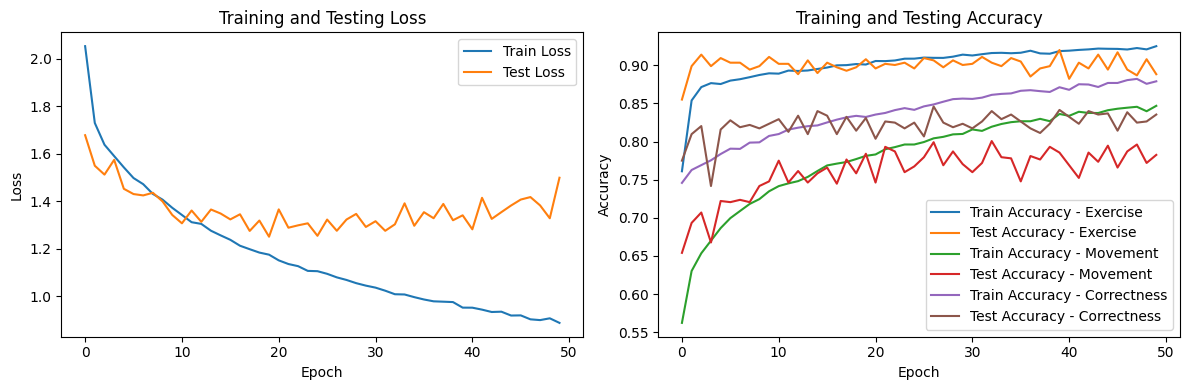

In [82]:
# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_acc_exercise, label='Train Accuracy - Exercise')
plt.plot(test_acc_exercise, label='Test Accuracy - Exercise')
plt.plot(train_acc_movement, label='Train Accuracy - Movement')
plt.plot(test_acc_movement, label='Test Accuracy - Movement')
plt.plot(train_acc_correctness, label='Train Accuracy - Correctness')
plt.plot(test_acc_correctness, label='Test Accuracy - Correctness')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [111]:
print(f'Test Loss: {test_loss:.4f}')
print(f'Exercise Classification Accuracy: {test_acc_ex:.4f}')
print(f'Movement Classification Accuracy: {test_acc_mov:.4f}')
print(f'Correctness Classification Accuracy: {test_acc_corr:.4f}')

Test Loss: 1.4999
Exercise Classification Accuracy: 0.8882
Movement Classification Accuracy: 0.7825
Correctness Classification Accuracy: 0.8353


In [114]:
model_save_path = 'model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to model.pth
